In [144]:
# Compare two matchms tables

In [178]:
# %pip install matplotlib --upgrade

from pipeline_utils import get_galaxy_filename
import numpy as np
import pandas as pd
from matplotlib_venn import venn2 as venn2_
import matplotlib.pyplot as plt


def venn2(*args):
    v = venn2_(*args, set_labels = ('Predicted', 'Ground'))
    v.get_patch_by_id('100').set_color('red')
    v.get_patch_by_id('010').set_color('orange')
    v.get_patch_by_id('110').set_color('green')

In [273]:
model = "Orig_exp_12"

fres1 = get_galaxy_filename('- Original', 'tmp', None)
fres2 = get_galaxy_filename(f'- {model}', 'tmp', None)

fref = "tmp/6_KC_Confirmed_seminalplasma.csv.csv"



# reference_lib = "../data/1_rcx_gc-orbitrap_metabolites_20210817.msp.msp"
# concs = ["all"]
# # if the predictions were generated in this galaxy session set to True
# is_fresh = False
# suffix = "" if is_fresh else ".txt"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
fres1

'tmp/1_matchms output formatter _get-thresholded-data_ on data 129 and data 128 - Original.tsv'

In [275]:
ref = pd.read_csv(fref)
res1 = pd.read_csv(fres1, sep="\t")
res2 = pd.read_csv(fres2, sep="\t")

In [276]:
len(set(res1["query"]))

41

In [277]:
len(res1), len(res2)

(143, 324)

In [278]:
th_m = 2
th_s = 0.2


### First eval: only set:

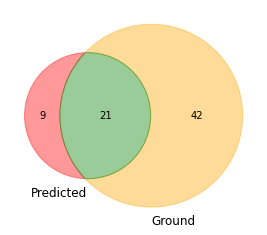

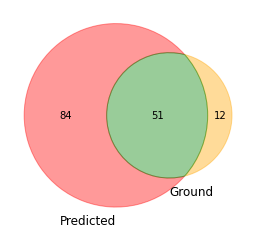

In [279]:
ground = set(ref["Metabolite name"])
orig = set(res1.reference) 
new = set(res2.reference) 

orig = res1[((res1.matches > th_m) & (res1.score > th_s))].reference
venn2((set(orig), ground))
plt.show()
venn2((set(new), ground))

### Second eval: take the best compound for each spectra and set compare

In [280]:
# add helper collumn - the best criterion in the score as in rcx galaxy formatter
res1["total"] = res1["score"]
res2["total"] = res2["score"]#

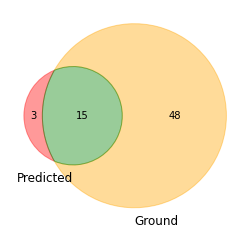

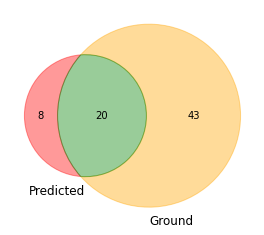

In [281]:
x  = res1[((res1.matches > th_m) & (res1.score > th_s))]

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
orig = x.reference

venn2((set(orig), ground))
plt.show()

x  = res2[((res2.matches > th_m) & (res2.score > th_s))]

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
new = x.reference
venn2((set(new), ground))

### Third eval: take the best compound for each spectra and compare with maximal RI difference

In [282]:
import sys
sys.path.append("..")

import pandas as pd
import matchms
from matchms.importing import load_from_msp
from data_utils import spectrum_processing
from pipeline_utils import get_galaxy_filename

def get_spectra(path):
    spectrums = [spectrum_processing(s, min_rel_int=None, n_required_peaks=1) for s in load_from_msp(path, metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    return spectrums

# super inefficent variant :))
def get_RTI(c_ids, measured):
    rts =[]
    ris = []
    for c_id in c_ids:
        for spectrum in measured:
            if c_id == spectrum.metadata["compound_name"]:
                rts.append(spectrum.metadata["retention_time"])
                ris.append(float(spectrum.metadata["retention_index"]))
                break
    return rts, ris

In [283]:
ref[["Metabolite name", "Average RI"]]

,Metabolite name,Average RI
0,2-Methylmalonic acid_2TMS,1224.68
1,Acetylgalactosamine_4TMS,2071.84
2,Acetylgalactosamine_5TMS isomer 1,2065.37
3,Acetylgalactosamine_5TMS isomer 2,2088.77
4,Acetylglucosamine_5TMS isomer 1,2070.17
...,...,...
60,Threonine_3TMS spectra 1,1377.14
61,Threonine_3TMS spectra 2,1378.30
62,trans-Aconitic acid_3TMS,1732.44
63,Tryptophan_3TMS,2208.86


In [284]:
# add helper colums - measured spectrum RI, ground compound RI
library = get_spectra("tmp/5_rcx_gc-orbitrap_metabolites_20210817.msp.msp")
measured1 = get_spectra(get_galaxy_filename(f"_Original", "tmp"))
measured2 = get_spectra(get_galaxy_filename(f"_{model}", "tmp"))

enh = []
for res, mes in zip([res1, res2], [measured1, measured2]):
    res["measured_RI"] = get_RTI(res["query"], mes)[1]
    
    tmp = ref.rename(columns={"Metabolite name": "reference", "Average RI": "ground_RI"})
    enh.append(pd.merge(tmp[["reference", "ground_RI"]], res, how="right", on="reference"))
    enh[-1].loc[pd.isna(enh[-1].ground_RI), "ground_RI"] = -1000
    enh[-1]["RI_diff"] = abs(enh[-1]["ground_RI"] - enh[-1]["measured_RI"])   
res1, res2 = enh

({'ionmode': 'Negative',
  'spectrumtype': 'Centroid',
  'num_peaks': '9',
  'compound_name': 'C40',
  'retention_time': '347.74',
  'retention_index': '2238.555556'},
 array([189.05321692, 297.22449424, 315.23451078, 341.28586572,
        342.28978482, 359.29806352, 360.30000178, 487.18163949,
        502.20436881]))

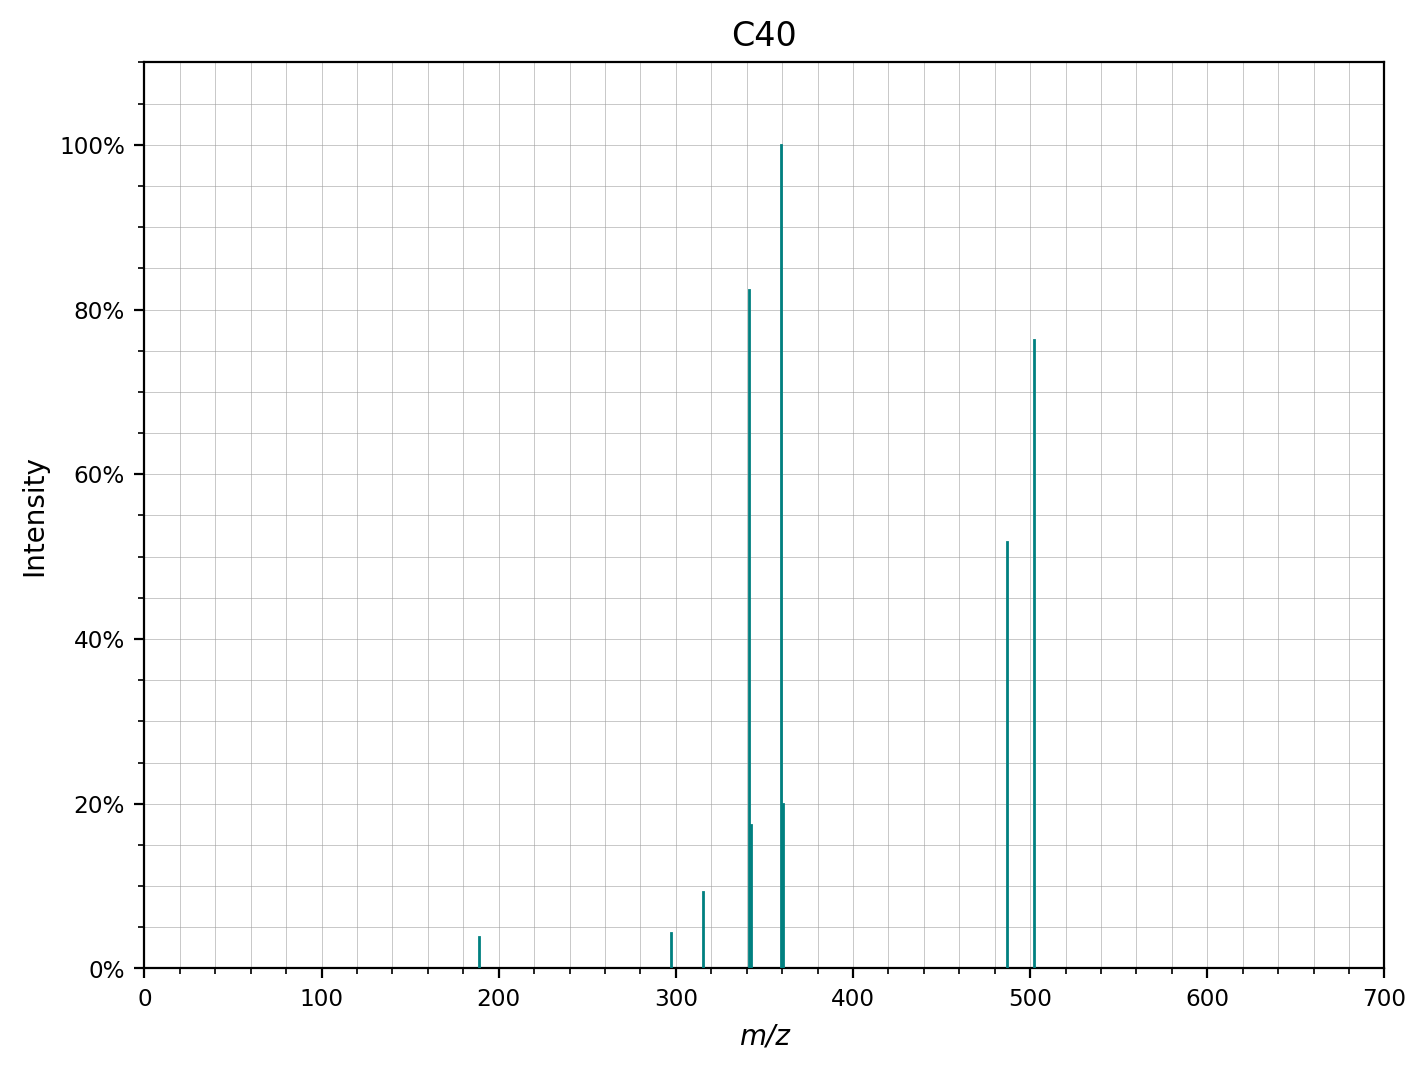

In [285]:
u = -7

measured1[u].plot()
measured1[u].metadata, measured1[u].peaks.mz

In [286]:
res1

,reference,ground_RI,query,matches,score,total,measured_RI,RI_diff
0,Myristic acid_1TMS,-1000.00,C01,1,0.004459,0.004459,1824.952381,2824.952381
1,Myristic acid_1TMS,-1000.00,C67,3,0.011347,0.011347,1848.666667,2848.666667
2,Acetylglutamine_2TMS,-1000.00,C02,3,0.014779,0.014779,1917.708333,2917.708333
3,Acetylglutamine_2TMS,-1000.00,C39,1,0.009530,0.009530,1913.281250,2913.281250
4,Acetylglutamine_2TMS,-1000.00,C64,1,0.017129,0.017129,1930.260417,2930.260417
...,...,...,...,...,...,...,...,...
142,Phenylalanine_2TMS,1620.99,C63,4,0.491230,0.491230,1621.527778,0.537778
143,Galactitol_6TMS,-1000.00,C64,1,0.006415,0.006415,1930.260417,2930.260417
144,Glycylleucine_3TMS,-1000.00,C64,1,0.047464,0.047464,1930.260417,2930.260417
145,Dopamine_3TMS,-1000.00,C65,1,0.007276,0.007276,1810.619048,2810.619048


In [287]:
max_RI_diff = 30


# assert sum(abs(res2["ground_RI"] - res2["measured_RI"]) >max_RI_diff) == 0
sum(abs(res1["RI_diff"]) > max_RI_diff), sum(abs(res1["RI_diff"]) > max_RI_diff) - sum(res1.ground_RI == -1000)

(70, 0)

In [288]:
res1

,reference,ground_RI,query,matches,score,total,measured_RI,RI_diff
0,Myristic acid_1TMS,-1000.00,C01,1,0.004459,0.004459,1824.952381,2824.952381
1,Myristic acid_1TMS,-1000.00,C67,3,0.011347,0.011347,1848.666667,2848.666667
2,Acetylglutamine_2TMS,-1000.00,C02,3,0.014779,0.014779,1917.708333,2917.708333
3,Acetylglutamine_2TMS,-1000.00,C39,1,0.009530,0.009530,1913.281250,2913.281250
4,Acetylglutamine_2TMS,-1000.00,C64,1,0.017129,0.017129,1930.260417,2930.260417
...,...,...,...,...,...,...,...,...
142,Phenylalanine_2TMS,1620.99,C63,4,0.491230,0.491230,1621.527778,0.537778
143,Galactitol_6TMS,-1000.00,C64,1,0.006415,0.006415,1930.260417,2930.260417
144,Glycylleucine_3TMS,-1000.00,C64,1,0.047464,0.047464,1930.260417,2930.260417
145,Dopamine_3TMS,-1000.00,C65,1,0.007276,0.007276,1810.619048,2810.619048


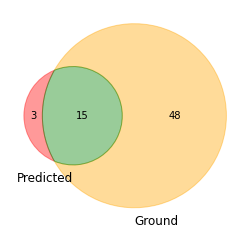

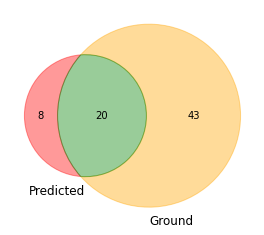

In [289]:
x = res1[((res1.matches > th_m) & (res1.score > th_s))]
x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total', "RI_diff"]]
x.loc[x.RI_diff > max_RI_diff, "reference"] += "x"
orig = x.reference

venn2((set(orig), ground))
plt.show()

x  = res2[((res2.matches > th_m) & (res2.score > th_s))]
x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total', "RI_diff"]]
x.loc[x.RI_diff > max_RI_diff, "reference"] += "x"
new = x.reference
venn2((set(new), ground))

In [290]:
set(new).difference(orig)

{'Cholestanol_1TMSx',
 'Creatinine_3TMS',
 'Guanine_3TMS',
 'Histidine_4TMS',
 'Hypoxanthine_2TMS',
 'Isocitric acid_4TMSx',
 'Proline_2TMS',
 'Spermine_6TMS',
 'Urea_2TMSx',
 'Xanthine_3TMSx',
 'gamma-Aminobutyric acid_2TMSx'}

In [291]:
set(orig).difference(new)

{'Stearic acid_1TMS'}

In [292]:
set(orig).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Acetylglucosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Fructose_5TMS isomer 2',
 'Glycine_3TMS',
 'Histidine_3TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Serine_3TMS',
 'Stearic acid_1TMS',
 'Threonine_3TMS spectra 1'}

In [293]:
set(new).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Acetylglucosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Creatinine_3TMS',
 'Fructose_5TMS isomer 2',
 'Glycine_3TMS',
 'Guanine_3TMS',
 'Histidine_3TMS',
 'Histidine_4TMS',
 'Hypoxanthine_2TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Proline_2TMS',
 'Serine_3TMS',
 'Spermine_6TMS',
 'Threonine_3TMS spectra 1'}

In [294]:
set(new).difference(orig).intersection(ground)

{'Creatinine_3TMS',
 'Guanine_3TMS',
 'Histidine_4TMS',
 'Hypoxanthine_2TMS',
 'Proline_2TMS',
 'Spermine_6TMS'}

### Final eval: take the n best compound for each spectra and compare with maximal RI difference

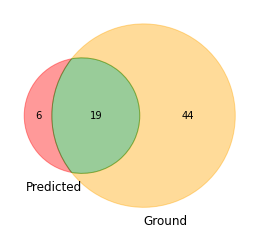

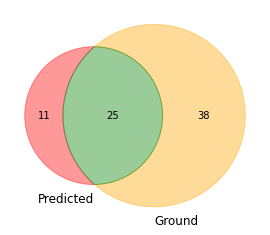

In [295]:
TOP = 3


x = res1[((res1.matches > th_m) & (res1.score > th_s))]
x = x.groupby("query", group_keys=False).apply(pd.DataFrame.nlargest, n=TOP, columns=['score'])


x.loc[x.RI_diff > max_RI_diff, "reference"] += "x"
orig = x.reference

venn2((set(orig), ground))
plt.show()

x  = res2[((res2.matches > th_m) & (res2.score > th_s))]
x = x.groupby("query", group_keys=False).apply(pd.DataFrame.nlargest, n=TOP, columns=['score'])
x.loc[x.RI_diff > max_RI_diff, "reference"] += "x"
new = x.reference
venn2((set(new), ground))

In [296]:
TOP = 3

orig_f1 = np.zeros(shape=(20, 20))
new_f1 = orig_f1.copy()

stat_orig = np.ones(63) * (100)
stat_new = stat_orig.copy()
for i, n_m in enumerate(range(1,21)):
    for j, n_s in enumerate(np.arange(0,1,0.05)):
        for res, grid, stat in zip([res1, res2], [orig_f1, new_f1], [stat_orig, stat_new]):
            p = set(res[((res.matches > n_m) & (res.score > n_s))].reference)
            
            x  = res[((res.matches > n_m) & (res.score > n_s))]
            
            if not x.empty:
                x = x.groupby("query", group_keys=False).apply(pd.DataFrame.nlargest, n=TOP, columns=['score'])
                x.loc[x["RI_diff"] > max_RI_diff, "reference"] += "x"
            
            p = set(x.reference)
            
            TP = len(p.intersection(ground))
            FP = len(p.difference(ground))
            FN = len(ground.difference(p))
            stat[TP] = min(FP, stat[TP])
            grid[i,j] = TP/(TP + 0.5*(FN+FP)) if (TP + 0.5*(FN+FP)) != 0 else 0
stat_orig[stat_orig == 100] = np.nan
stat_new[stat_new == 100] = np.nan

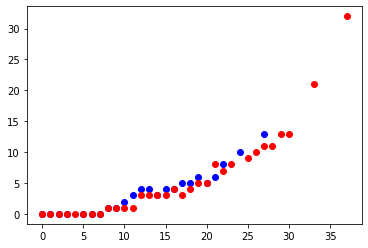

In [297]:
plt.scatter(x=np.arange(63), y=stat_orig, color="blue")
plt.scatter(x=np.arange(63), y=stat_new, color = "red")

In [298]:
stat_orig - stat_new

array([ 0.,  0.,  0.,  0., nan,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,
        1.,  0.,  1.,  0.,  2.,  1.,  1.,  0., -2.,  1., nan, nan, nan,
       nan,  2., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

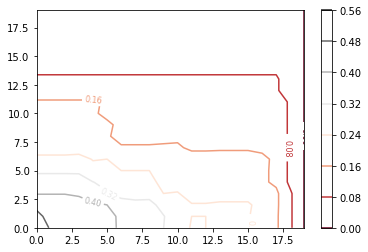

In [299]:
c = plt.contour(orig_f1, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()


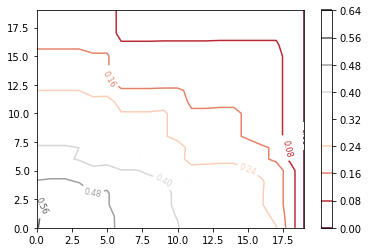

In [300]:
c = plt.contour(new_f1, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()

In [301]:
orig_f1.sum()

59.69634250761248

In [302]:
new_f1.sum()

87.21105779211018

In [303]:
set(ground).difference(orig)

{'2-Methylmalonic acid_2TMS',
 'Acetylgalactosamine_5TMS isomer 2',
 'Allose_5TMS isomer 1',
 'Allose_5TMS isomer 2',
 'Arabitol_5TMS',
 'Arginine_3TMS',
 'Asparagine_2TMS',
 'Asparagine_4TMS isomer 1',
 'Asparagine_4TMS isomer 2',
 'Creatinine_3TMS',
 'D27-Myristic acid_TMS spectra 1',
 'D4-Succinic acid_2TMS spectra 1',
 'Fumaric acid_2TMS',
 'Glucose_5TMS isomer 1',
 'Glucuro-3,6-lactone_3TMS isomer 2',
 'Guanine_3TMS',
 'Histidine_4TMS',
 'Hypoxanthine_2TMS',
 'Isoleucine_2TMS',
 'Itaconic acid_2TMS',
 'Leucine_2TMS',
 'Lysine_3TMS',
 'Malic acid_3TMS',
 'Maltotriose_11TMS isomer 1',
 'Maltotriose_11TMS isomer 2',
 'Mannitol_6TMS',
 'Mannose_5TMS isomer 1',
 'Mannose_5TMS isomer 2',
 'Methionine_2TMS',
 'Orotic acid_3TMS',
 'Proline_2TMS',
 'Pyroglutamic acid_2TMS',
 'Ribitol_5TMS',
 'Ribose_4TMS',
 'Serine_4TMS',
 'Sorbitol_6TMS',
 'Spermidine_5TMS',
 'Spermine_6TMS',
 'Taurine_3TMS',
 'Threonic acid_4TMS',
 'Tryptophan_3TMS',
 'Tyrosine_3TMS',
 'gamma-Aminobutyric acid_3TMS',
 't

In [304]:
set(ground).difference(new)

{'2-Methylmalonic acid_2TMS',
 'Acetylgalactosamine_5TMS isomer 2',
 'Allose_5TMS isomer 1',
 'Allose_5TMS isomer 2',
 'Arabitol_5TMS',
 'Asparagine_2TMS',
 'Asparagine_4TMS isomer 1',
 'Asparagine_4TMS isomer 2',
 'D27-Myristic acid_TMS spectra 1',
 'D4-Succinic acid_2TMS spectra 1',
 'Fumaric acid_2TMS',
 'Glucose_5TMS isomer 1',
 'Glucuro-3,6-lactone_3TMS isomer 2',
 'Isoleucine_2TMS',
 'Itaconic acid_2TMS',
 'Leucine_2TMS',
 'Lysine_3TMS',
 'Malic acid_3TMS',
 'Maltotriose_11TMS isomer 1',
 'Maltotriose_11TMS isomer 2',
 'Mannitol_6TMS',
 'Mannose_5TMS isomer 1',
 'Mannose_5TMS isomer 2',
 'Methionine_2TMS',
 'Orotic acid_3TMS',
 'Pyroglutamic acid_2TMS',
 'Ribitol_5TMS',
 'Ribose_4TMS',
 'Serine_4TMS',
 'Sorbitol_6TMS',
 'Spermidine_5TMS',
 'Stearic acid_1TMS',
 'Taurine_3TMS',
 'Threonic acid_4TMS',
 'Tryptophan_3TMS',
 'Tyrosine_3TMS',
 'gamma-Aminobutyric acid_3TMS',
 'trans-Aconitic acid_3TMS'}